In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import sys
import os

# Add src directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "src")))

from pricing.triple_win import TripleWinPricing, TrackingTripleWinPricing
from pricing.buyer import BuyerBlock
import numpy as np

import matplotlib.pyplot as plt


In [ ]:
# I datasets, J models; shapley_values[i,j] = SV_{i|j} >= 0

np.random.seed(42)  
I, J = 10, 5
shapley_values = np.random.uniform(0.02, 0.15, size=(I, J))

# Per-model margin δ_j
delta = np.full(J, 0.05)

# Dataset-side offsets κ_{D_i} and lower/upper bounds
kappa_D = 0.02 * np.ones(I)
C_var   = 0.05 * np.ones(I)
bar_p_DtoM = 0.50 * np.ones((I, J))

# Build buyer blocks for each model j
buyers = []
for j in range(J):
    K_j = 2                      # number of buyers for model j
    kappa_mb = 0.01 * np.ones(K_j)
    p0       = 0.30 * np.ones(K_j)     # buyer lower bounds
    R        = 1.00 * np.ones(K_j)     # buyer reserves (upper bounds)
    omega    = np.ones(K_j) / K_j      # weights sum ≤ 1
    buyers.append(BuyerBlock(kappa_mb=kappa_mb, p0=p0, R=R, omega=omega))

solver = TripleWinPricing(
    shapley_values=shapley_values,
    delta=delta,
    kappa_D=kappa_D,
    buyers=buyers,
    C_var=C_var,
    bar_p_DtoM=bar_p_DtoM,
    tol=1e-6,
    max_iter=1000,
    verbose=False,
)

result = solver.fit()
p_DtoM = result["p_DtoM"]      # np.ndarray (I,J): p_{D_i->M_j}
p_MtoB = result["p_MtoB"]      # list of length J; each np.ndarray (K_j,)

print("iterations:", result["iterations"], "residual:", result["residual"])


iterations: 654 residual: 9.935788498695811e-07


In [4]:
def make_init(seed_shift: int):
    rng = np.random.default_rng(1000 + seed_shift)

    alpha = rng.uniform(0.0, 1.0, size=(I, J))
    p_DtoM_init = C_var[:, None] * (1 - alpha) + bar_p_DtoM * alpha

    buyers_init = []
    for j, blk in enumerate(buyers):
        beta = rng.uniform(0.0, 1.0, size=blk.p0.shape)
        p_init = blk.p0 * (1 - beta) + blk.R * beta
        buyers_init.append(BuyerBlock(
            kappa_mb=blk.kappa_mb.copy(),
            p0=blk.p0.copy(),
            R=blk.R.copy(),
            omega=blk.omega.copy(),
            p_init=p_init
        ))
    return p_DtoM_init, buyers_init

inits = [make_init(s) for s in range(5)]

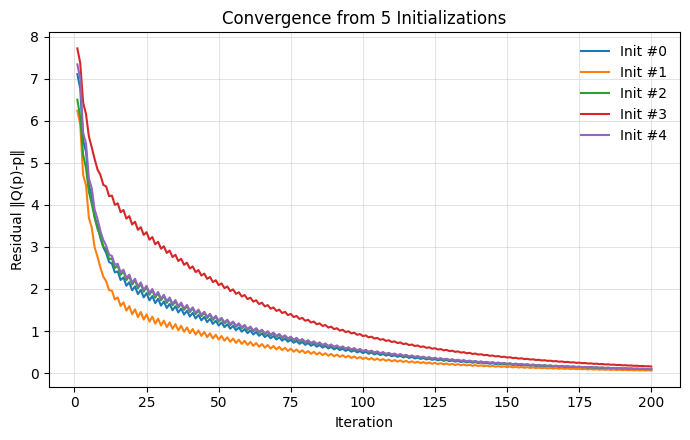

In [5]:
results = []
for idx, (pD_init, buyers_init) in enumerate(inits):
    solver = TrackingTripleWinPricing(
        shapley_values=shapley_values,
        delta=delta,
        kappa_D=kappa_D,
        buyers=buyers_init,
        C_var=C_var,
        bar_p_DtoM=bar_p_DtoM,
        p_DtoM_init=pD_init,
        tol=1e-8,
        max_iter=200,
        verbose=False,
    )
    info = solver.fit()
    results.append({
        "label": f"Init #{idx}",
        "res_hist": info["res_hist"],
        "maxchg_hist": info["maxchg_hist"],
        "iters": info["iterations"]
    })

plt.figure(figsize=(7, 4.5))
for r in results:
    y = r["res_hist"]
    x = np.arange(1, len(y) + 1)
    plt.plot(x, y, label=r["label"])
# plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Residual ‖Q(p)-p‖")
plt.title("Convergence from 5 Initializations")
plt.grid(True, which="both", linewidth=0.5, alpha=0.5)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

# plt.figure(figsize=(7, 4.5))
# for r in results:
#     y = r["maxchg_hist"]
#     x = np.arange(1, len(y) + 1)
#     plt.plot(x, y, label=r["label"])
# # plt.yscale("log")
# plt.xlabel("Iteration")
# plt.ylabel("Max Change After Projection")
# plt.title("Per-Iteration Max Change")
# plt.grid(True, which="both", linewidth=0.5, alpha=0.5)
# plt.legend(frameon=False)
# plt.tight_layout()
# plt.show()


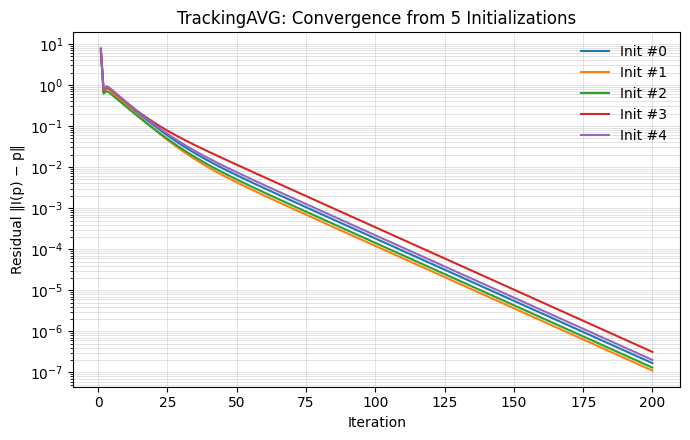

In [71]:
from pricing.average import TrackingAVGPricing


# ---- Solve with TrackingAVG and collect histories
results = []
for idx, (pD_init, buyers_init) in enumerate(inits):
    solver = TrackingAVGPricing(
        shapley_values=shapley_values,
        delta=delta,
        kappa_D=kappa_D,
        buyers=buyers_init,     # note: pass the per-init buyers with p_init seeds
        C_var=C_var,            # kept for API compatibility; not used for clipping
        bar_p_DtoM=bar_p_DtoM,  # kept for API compatibility; not used for clipping
        p_DtoM_init=pD_init,    # just an initial guess
        tol=1e-8,
        max_iter=200,
        verbose=False,
        gamma=0.5,              # averaged iteration parameter
    )
    info = solver.fit()
    results.append({
        "label": f"Init #{idx}",
        "res_hist": info["res_hist"],
        "maxchg_hist": info["maxchg_hist"],
        "iters": info["iterations"]
    })

# ---- Plot: residual vs iteration (log y), five curves
plt.figure(figsize=(7, 4.5))
for r in results:
    y = r["res_hist"]
    x = np.arange(1, len(y) + 1)
    plt.plot(x, y, label=r["label"])
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Residual ‖I(p) − p‖")
plt.title("TrackingAVG: Convergence from 5 Initializations")
plt.grid(True, which="both", linewidth=0.5, alpha=0.5)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

# # ---- Optional: plot max-change vs iteration (log y), five curves
# plt.figure(figsize=(7, 4.5))
# for r in results:
#     y = r["maxchg_hist"]
#     x = np.arange(1, len(y) + 1)
#     plt.plot(x, y, label=r["label"])
# plt.yscale("log")
# plt.xlabel("Iteration")
# plt.ylabel("Max Change |p^{t+1} − p^t|")
# plt.title("TrackingAVG: Per-Iteration Max Change")
# plt.grid(True, which="both", linewidth=0.5, alpha=0.5)
# plt.legend(frameon=False)
# plt.tight_layout()
# plt.show()

=== Fixed Scenario Diagnostics ===
SupplyFirstPricing    sum(p*)=17.808076  inside_frac=0.933
DemandFirstPricing    sum(p*)=11.769337  inside_frac=1.000
BrokerCentricPricing  sum(p*)=19.017045  inside_frac=0.917
TripleWinPricing      sum(p*)=16.216398  inside_frac=0.967


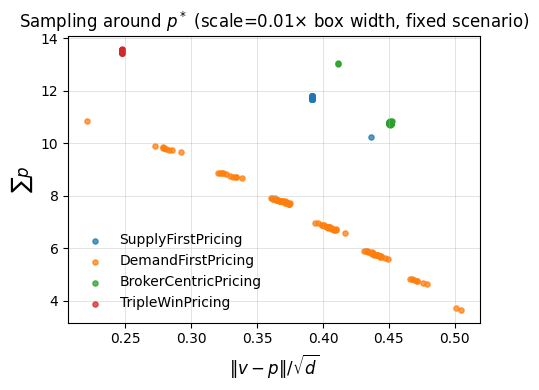

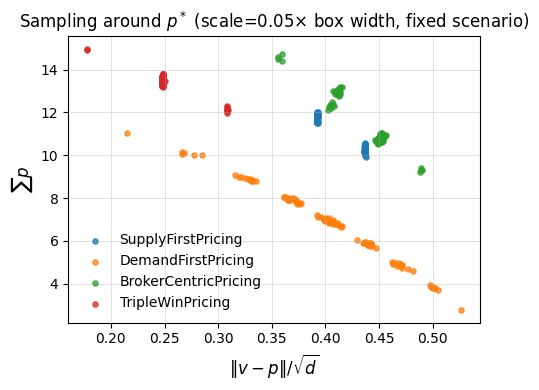

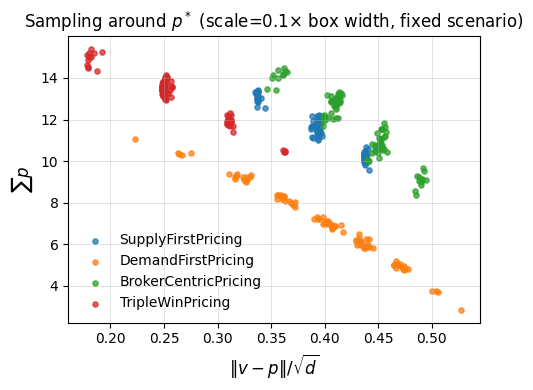

In [114]:
# --- Fixed scenario (deterministic setup) + sampling plots ---

import sys, os
import numpy as np
import matplotlib.pyplot as plt

# Ensure imports work
if "src" not in sys.path:
    sys.path.append(os.path.abspath("src"))

from pricing.buyer import BuyerBlock
from pricing.supply_first import SupplyFirstPricing
from pricing.demand_first import DemandFirstPricing
from pricing.broker_centric import BrokerCentricPricing
from pricing.triple_win import TripleWinPricing


# =======================
# 1. Fixed deterministic setup
# =======================
np.random.seed(42)
I, J = 10, 5
shapley_values = np.random.uniform(0.01, 0.02, size=(I, J))

delta = np.full(J, 0.05)

# ---- Data→Model (dataset sellers) ----
dataseller_min_price = 0.02 * np.ones(I)           # κ_D (lower bound per dataset)
dataseller_max_price = np.random.uniform(0.06, 0.10, size=(I, J))
dataseller_init_price = (dataseller_min_price[:, None] + dataseller_max_price) / 2.0

# ---- Model→Buyer (model buyers) ----
buyers = []
for j in range(J):
    K_j = 2
    modelbuyer_max_price = np.random.uniform(1.2, 2.5, size=K_j)  

    modelbuyer_min_price = np.minimum(
        modelbuyer_max_price - 1e-6,         
        np.random.uniform(0.9, 1.1, size=K_j)
    )
    omega = np.ones(K_j) / K_j
    buyers.append(
        BuyerBlock(
            kappa_mb=modelbuyer_min_price, 
            p0=modelbuyer_min_price,
            R=modelbuyer_max_price,
            omega=omega,
        )
    )


# =======================
# 2. Helper functions
# =======================
def flatten_prices(p_MtoB_list, p_DtoM_mat):
    parts = [p.flatten() for p in p_MtoB_list]
    parts.append(p_DtoM_mat.flatten())
    return np.concatenate(parts, axis=0)

def flatten_quotes(vM_list, vD_mat):
    parts = [v.flatten() for v in vM_list]
    parts.append(vD_mat.flatten())
    return np.concatenate(parts, axis=0)

def build_bounds_vec(buyers, dataseller_min_price, dataseller_max_price):
    """
    Build feasibility bounds vectors matching the flattened order:
      - First all model→buyer edges (per BuyerBlock)
      - Then all data→model edges (matrix flattened column-wise)
    """
    lowers, uppers = [], []

    # model→buyer edges
    for blk in buyers:
        lowers.append(blk.kappa_mb.flatten())  # modelbuyer_min_price
        uppers.append(blk.R.flatten())         # modelbuyer_max_price

    # data→model edges
    I, J = dataseller_max_price.shape
    lowers.append(np.repeat(dataseller_min_price, J).astype(float))
    uppers.append(dataseller_max_price.flatten().astype(float))

    lb = np.concatenate(lowers, axis=0)
    ub = np.concatenate(uppers, axis=0)
    return lb, ub


def run_method(method_cls, SV, delta, buyers, dataseller_min_price, dataseller_max_price, dataseller_init_price):
    buyers_init = []
    for blk in buyers:
        buyers_init.append(
            BuyerBlock(
                kappa_mb=blk.kappa_mb.copy(), # modelbuyer_init_price
                p0=blk.kappa_mb.copy(),     # using κ as lower bound
                R=blk.R.copy(),
                omega=blk.omega.copy(),
                p_init=blk.kappa_mb.copy(),
            )
        )

    solver = method_cls(
        shapley_values=SV,
        delta=delta,
        kappa_D=dataseller_min_price,
        buyers=buyers_init,
        C_var=dataseller_min_price,           # API placeholder, not used (kept for compatibility)
        bar_p_DtoM=dataseller_max_price,
        p_DtoM_init=dataseller_init_price,
        tol=1e-10,
        max_iter=10000,
        verbose=False,
    )
    _ = solver.fit()

    p_star = flatten_prices(solver.p_MtoB, solver.p_DtoM)
    v = flatten_quotes(solver.forward_quote(), solver.backward_quote())
    lb, ub = build_bounds_vec(solver.buyers, solver.kappa_D, solver.bar_p_DtoM)
    return p_star, v, lb, ub, solver


def sample_points_scaled(p_star, v_fixed, lb, ub, scale, n_samples, rng):
    d = p_star.size
    width = np.maximum(ub - lb, 1e-12)
    sigma_vec = scale * width
    noise = rng.normal(0.0, 1.0, size=(n_samples, d)) * sigma_vec[None, :]
    P = p_star[None, :] + noise
    P = np.where((P < lb[None, :]) | (P > ub[None, :]), 0.0, P)
    diff = v_fixed[None, :] - P
    x = np.linalg.norm(diff, axis=1) / np.sqrt(d)
    y = np.sum(P, axis=1)
    return x, y


# =======================
# 3. Run methods
# =======================
methods = [
    ("SupplyFirstPricing",   SupplyFirstPricing),
    ("DemandFirstPricing",   DemandFirstPricing),
    ("BrokerCentricPricing", BrokerCentricPricing),
    ("TripleWinPricing",     TripleWinPricing),
]

pstars, vs, bounds = {}, {}, {}

print("=== Fixed Scenario Diagnostics ===")
for name, cls in methods:
    p_star, v_fix, lb, ub, solver = run_method(
        cls, shapley_values, delta, buyers,
        dataseller_min_price, dataseller_max_price, dataseller_init_price
    )
    pstars[name] = p_star
    vs[name] = v_fix
    bounds[name] = (lb, ub)
    inside = np.logical_and(p_star >= lb, p_star <= ub)
    print(f"{name:20s}  sum(p*)={p_star.sum():.6f}  inside_frac={inside.mean():.3f}")


# =======================
# 4. Sampling and plotting
# =======================
rng = np.random.default_rng(2025)
scales = [0.01, 0.05, 0.1]
n_per_scale = 100

for scale in scales:
    plt.figure(figsize=(5, 4))
    for name, _ in methods:
        p_star = pstars[name]
        v_fix  = vs[name]
        lb, ub = bounds[name]
        x, y = sample_points_scaled(p_star, v_fix, lb, ub, scale, n_per_scale, rng)
        plt.scatter(x, y, s=14, label=name, alpha=0.75)

    plt.xlabel(r"$\|v - p\|/\sqrt{d}$", fontsize=12)
    plt.ylabel(r"$\sum p$", fontsize=12)
    plt.title(f"Sampling around $p^*$ (scale={scale}× box width, fixed scenario)", fontsize=12)
    plt.grid(True, which="both", linewidth=0.5, alpha=0.5)
    plt.legend(frameon=False)
    plt.tight_layout()
    plt.show()
